In [5]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for statistical inference
from statsmodels.tsa.stattools import adfuller

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules used for time series forecasting
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import evaluation

# Modules used for preprocessing
from datetime import datetime
import preprocess

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [6]:
temperature["date"] = pd.to_datetime(temperature[["year", "month", "day"]])
temperature = temperature.drop(["year", "month", "day"], axis=1)

precipitation["date"] = pd.to_datetime(precipitation[["year", "Month", "Day"]])
precipitation = precipitation.drop(["year", "Month", "Day"], axis=1)

In [7]:
weather = temperature.merge(precipitation)

# The time-series (original)

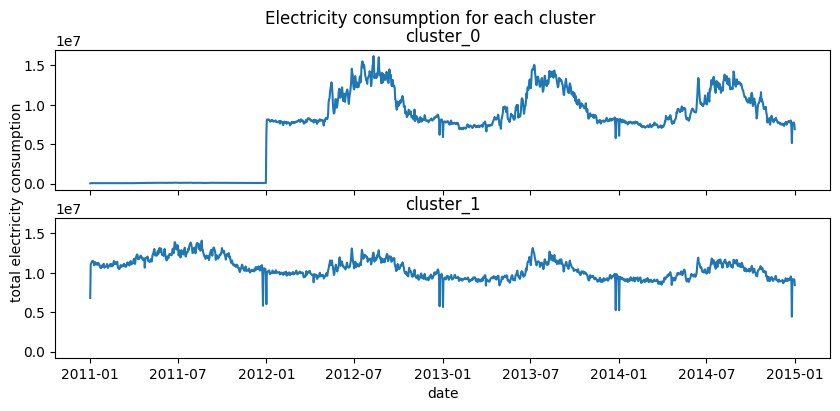

In [ ]:
clusters = ["cluster_0", "cluster_1"]

fig, axs = plt.subplots(2, 1, figsize = (10, 4), 
                        sharex = True, sharey = True)

for i in range(0, len(clusters)):
    axs[i].plot(electricity[clusters[i]])
    axs[i].set_title(clusters[i])

plt.xlabel("date")
fig.text(0.08, 0.5, 'total electricity consumption', 
         va='center', rotation='vertical')
plt.suptitle("Electricity consumption for each cluster")
plt.show()

The time series for each cluster are not stationary but we can verify this with Augmented Dickey-Fuller test.

# Test for stationarity

In [56]:
test_res = adfuller(electricity["cluster_0"])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41206.36180121677),
 'p-value': np.float64(0.3998314678325287),
 'samples': 1451,
 't-critical values': {'1%': np.float64(-3.4348647527922824),
                       '10%': np.float64(-2.567831568508802),
                       '5%': np.float64(-2.863533960720434)},
 'test statistic': np.float64(-1.7613115049630526),
 'used lags': 9}


In [57]:
test_res = adfuller(electricity["cluster_1"])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41099.21400777679),
 'p-value': np.float64(0.47652336646294613),
 'samples': 1439,
 't-critical values': {'1%': np.float64(-3.4349024693573584),
                       '10%': np.float64(-2.5678404322793846),
                       '5%': np.float64(-2.8635506057382325)},
 'test statistic': np.float64(-1.612766797797905),
 'used lags': 21}


- In both cases, the p-value is greater than the alpha value (1%, 5%, and 10%). 
- Therefore, we fail to reject the null hypothesis which implies that there is non-stationarity in both the time series.

# Making the time series stationary

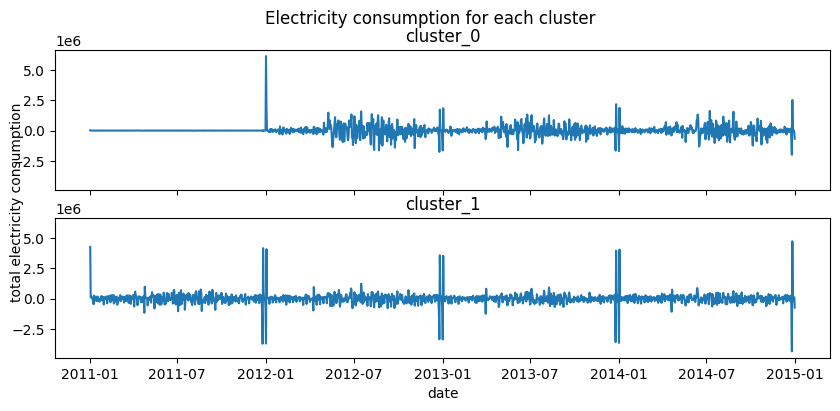

In [58]:
clusters = ["cluster_0", "cluster_1"]

fig, axs = plt.subplots(2, 1, figsize = (10, 4), 
                        sharex = True, sharey = True)

for i in range(0, len(clusters)):
    axs[i].plot(electricity[clusters[i]].diff())
    axs[i].set_title(clusters[i])

plt.xlabel("date")
fig.text(0.08, 0.5, 'total electricity consumption', 
         va='center', rotation='vertical')
plt.suptitle("Electricity consumption for each cluster")
plt.show()

These time-series appear to be relatively more stationary than the original time series but we can verify this using Augmented Dickey-Fuller test.

# Test for stationarity

In [60]:
test_res = adfuller(electricity["cluster_0"].diff()[1:])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41179.88985328503),
 'p-value': np.float64(3.3553336201809103e-28),
 'samples': 1451,
 't-critical values': {'1%': np.float64(-3.4348647527922824),
                       '10%': np.float64(-2.567831568508802),
                       '5%': np.float64(-2.863533960720434)},
 'test statistic': np.float64(-15.386321421705444),
 'used lags': 8}


In [61]:
test_res = adfuller(electricity["cluster_1"].diff()[1:])

pprint.pprint(dict(zip(["test statistic", "p-value", 
            "used lags", "samples",
            "t-critical values",
            "information criterion"], test_res)))

{'information criterion': np.float64(41072.15348509664),
 'p-value': np.float64(2.3976346501284293e-20),
 'samples': 1439,
 't-critical values': {'1%': np.float64(-3.4349024693573584),
                       '10%': np.float64(-2.5678404322793846),
                       '5%': np.float64(-2.8635506057382325)},
 'test statistic': np.float64(-11.188792407931913),
 'used lags': 20}


- In both cases, the p-value is less than the alpha value (1%, 5%, and 10%). 
- Therefore, we can reject the null hypothesis which implies that the time series are now stationary.

In [1]:
import evaluation